# Doom Deadly Corridor with Policy Gradient
The purpose of this scenario is to teach the agent to navigate towards his fundamental goal (the vest) and make sure he survives at the same time.

### Enviroment
Map is a corridor with shooting monsters on both sides (6 monsters in total). A green vest is placed at the oposite end of the corridor.Reward is proportional (negative or positive) to change of the distance between the player and the vest. If player ignores monsters on the sides and runs straight for the vest he will be killed somewhere along the way.

### Action
 - MOVE_LEFT
 - MOVE_RIGHT
 - ATTACK
 - MOVE_FORWARD
 - MOVE_BACKWARD
 - TURN_LEFT
 - TURN_RIGHT

### Rewards
 - +dX for getting closer to the vest.
 - -dX for getting further from the vest.
 - -100 death penalty


## Step 1: Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random                # Handling random number generation
import time                  # Handling time calculation
import cv2
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical
from vizdoom import *        # Doom Environment

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [2]:
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config("doom_files/deadly_corridor.cfg")
    
    # Load the correct scenario (in our case defend_the_center scenario)
    game.set_doom_scenario_path("doom_files/deadly_corridor.wad")
    
    possible_actions  = np.identity(7, dtype=int).tolist()
    
    return game, possible_actions
game, possible_actions = create_environment()

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is: ( 240 ,  320 )
No. of Actions:  [Button.MOVE_LEFT, Button.MOVE_RIGHT, Button.ATTACK, Button.MOVE_FORWARD, Button.MOVE_BACKWARD, Button.TURN_LEFT, Button.TURN_RIGHT]


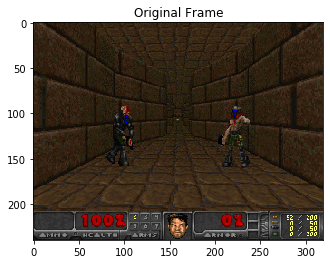

In [4]:
print("The size of frame is: (", game.get_screen_height(), ", ", game.get_screen_width(), ")")
print("No. of Actions: ", game.get_available_buttons())
game.init()
plt.figure()
plt.imshow(game.get_state().screen_buffer.transpose(1, 2, 0))
plt.title('Original Frame')
plt.show()
game.close()

In [8]:
def random_play():
    game.init()
    game.new_episode()
    score = 0
    while True:
        reward = game.make_action(possible_actions[3])
        done = game.is_episode_finished()
        score += reward
        time.sleep(0.01)
        if done:
            print("Your total score is: ", score)
            game.close()
            break
random_play()

Your total score is:  384.8349151611328


## Step 4:Preprocessing Frame

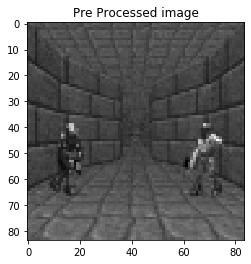

In [9]:
def preprocess_frame(screen):
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[0:-40, 60:-60]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (84, 84), interpolation = cv2.INTER_AREA)
    return screen

game.init()
plt.figure()
plt.imshow(preprocess_frame(game.get_state().screen_buffer.transpose(1, 2, 0)), cmap="gray")
game.close()
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [10]:
def stack_frame(stacked_frames, state, is_new=False):
    frame = preprocess_frame(state)
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 6: Creating Discount and Normalize Rewards

In [11]:
def discount_and_normalize_rewards(episode_rewards):
    R = 0
    returns = []
    eps = np.finfo(np.float32).eps.item()
    for r in episode_rewards[::-1]:
        R = r + GAMMA * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    return returns

## Step 7: Creating Deep Learning Model

In [12]:
class Network(nn.Module):
    def __init__(self, num_actions=6):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return F.softmax(self.fc5(x), dim=-1)

## Step 8: Creating out agent

In [13]:
GAMMA = .99            # discount factor
LR = 0.01              # learning rate 

class Agent():
    def __init__(self, action_size):
        self.action_size = action_size
        
        # Q-Network
        self.policy_net = Network(action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        
        self.saved_log_probs = []
        self.rewards = []
        
    
    def step(self, reward, log_probs):
        # Save rewards and log_probs
        self.rewards.append(reward)
        self.saved_log_probs.append(log_probs)
        
                
    def act(self, state):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.policy_net(state)
        action_probs = Categorical(probs)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        return action.item(), log_prob
        
    def reset(self):
        del self.saved_log_probs[:]
        del self.rewards[:]
        
    def learn(self, gamma):
        returns = discount_and_normalize_rewards(self.rewards)
        log_probs = torch.stack(self.saved_log_probs) 
        
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

## Step 9: Watching untrained agent play

In [14]:
agent = Agent(action_size=7)

# watch an untrained agent
game.init()
score = 0
state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _ = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  -70.69572448730469


## Step 10: Loading Agent
Uncomment line to load a pretrained agent

In [15]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

## Step 11: Train the Agent with Policy Gradient

In [13]:
def train(n_episodes=2000):
    global start_epoch
    game.init()
    for i_episode in range(start_epoch+1, n_episodes+1):
        game.new_episode()
        agent.reset()
        state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
        score = 0
        while True:
            action, log_probs = agent.act(state)
            reward = game.make_action(possible_actions[action])
            done = game.is_episode_finished()
            score += reward
            if done:
                break
            else:
                next_state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
                agent.step(reward, log_probs)
                state = next_state
        agent.learn(GAMMA)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    game.close()
    
    return scores

Episode 100	Average Score: 1.83


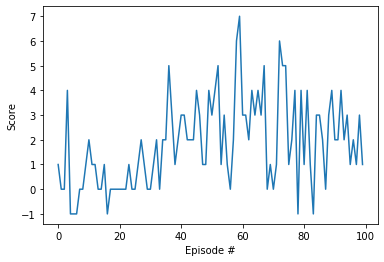

In [14]:
scores = train(100)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 12: Watch a Smart Agent!

In [20]:
game.init()
agent.reset()
score = 0
state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _ = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  4.0


In [17]:
game.close()